In [99]:
using ApproxFun
using SpecialFunctions

using LinearAlgebra
using SparseArrays

include("../src/Chebyshev.jl")
import .Chebyshev as CH

import Plots
using Plots

In [100]:
a, b = -1, 1
d = a..b;

In [105]:
x = Fun(identity,d);
D = Derivative(d);
alpha = 0;

In [106]:
L = (1-x^2)*D^2 - x*D + alpha^2;

In [111]:
Lt = L[1:100,1:100];

In [112]:
nullspace(Matrix(Lt))

100×1 Matrix{Float64}:
 -1.0
  3.688865842968159e-23
  5.704312173170703e-14
  4.10097348517331e-24
  5.097273759324472e-14
  1.3168076437619844e-24
  4.963625992431106e-14
  2.4483520927937194e-24
  4.865291633109046e-14
 -1.3194610168597405e-23
  4.735251627309601e-14
  8.866444427176082e-23
  4.54844421069335e-14
  ⋮
 -5.770342374513556e-15
 -1.3070885478791111e-16
 -4.850260653631302e-15
 -8.784456166701084e-17
 -3.722544675886215e-15
  2.1358980696887023e-16
 -2.524833797956065e-15
 -1.1248573953544253e-16
 -1.4052955060735933e-15
 -1.0823166820254363e-16
 -5.147015324357295e-16
  2.0575904054102585e-16

# try teukolsky radial equation

In [113]:
function radial_operator(
    nr::Integer,
    s::Integer,
    m::Integer,
    a::T,
    bhm::T,
    om::Complex{T},
    gamma::Complex{T},
    rmin::T,
    rmax::T,
) where {T<:Real}
    d = rmin..rmax;
    D1 = Derivative(d);
    D2 = D1^2;
    x = Fun(identity,d);

    A = (
        (2 * im) * om - 2 * (1 + s) * x +
        2 * (im * om * ((a^2) - 8 * (bhm^2)) + im * m * a + (s + 3) * bhm) * x^2 +
        4 * (2 * im * om * bhm - 1) * (a^2) * x^3
    )
    B = (
        (((a^2) - 16 * (bhm^2)) * (om^2) + 2 * (m * a + 2 * im * s * bhm) * om) +
        2 *
        (
            4 * ((a^2) - 4 * (bhm^2)) * bhm * (om^2) +
            (4 * m * a * bhm - 4 * im * (s + 2) * (bhm^2) + im * (a^2)) * om +
            im * m * a +
            (s + 1) * bhm
        ) *
        x +
        2 * (8 * (bhm^2) * (om^2) + 6 * im * bhm * om - 1) * (a^2) * x^2
    )
    return (-(x^2 - 2 * bhm * x^3 + (a^2) * x^4) * D2 + A * D1 + (B + gamma))[1:nr,1:nr]
end

radial_operator (generic function with 1 method)

In [114]:
nr = 100
s=-2
m=2
T=Float64
a = T(0)
bhm = T(1)

omega_0= T(0.34671099687916285)-T(0.27391487529123504)*im
gamma = T(4)+T(0)*im
rmin = T(0)
rmax = T(0.5)

0.5

In [115]:
rs = CH.cheb_pts(rmin,rmax,nr);

In [116]:
M = radial_operator(nr,s,m,a,bhm,omega_0,gamma,rmin,rmax);

In [117]:
null = nullspace(Matrix(M),rtol=1e-6)

100×1 Matrix{ComplexF64}:
     -0.9080344546913491 - 0.0im
      0.1061577796602797 + 0.38613898435066024im
    -0.07349983180826275 + 0.09743550100638908im
   -0.006285469260009044 - 0.012759761779926812im
   0.0010784139549932376 + 0.0011010278033625545im
 -0.00012936143537338463 - 0.00016040704622873048im
   1.2660445848064472e-5 + 3.145259362102165e-5im
   1.1757385875998949e-7 - 6.587289452915368e-6im
    -6.70816852156586e-7 + 1.2974753362121616e-6im
   2.9723588903379783e-7 - 2.0328569291794274e-7im
   -9.652123714176675e-8 + 8.284088622110414e-9im
   2.5359471904351505e-8 + 1.195627267330801e-8im
   -4.857235037791785e-9 - 7.137999663564543e-9im
                         ⋮
    7.16386585469797e-17 + 1.700029006457271e-16im
   3.165870343657673e-17 - 1.8149544367407344e-16im
   9.627715291671279e-17 + 1.8756697583999227e-16im
   3.903127820947816e-18 - 1.734723475976807e-16im
   7.323785675139582e-17 + 1.4116312285761268e-16im
 -1.6696713456276768e-17 - 1.0602141994192626e-16im
 

In [118]:
vect = CH.to_real(null[:,1])

100-element Vector{ComplexF64}:
 -0.8807005947455616 + 0.4717813190451966im
 -0.8805848703924601 + 0.47144123866776955im
 -0.8802383906775925 + 0.470421566529592im
 -0.8796632324404838 + 0.4687240094750596im
 -0.8788628464452447 + 0.4663514117753469im
 -0.8778420414677278 + 0.46330775438976im
 -0.8766069620978052 + 0.45959815386287206im
 -0.8751650603364871 + 0.4552288607894521im
 -0.8735250610907913 + 0.4502072577607853im
 -0.8716969216919094 + 0.44454185668830537im
 -0.8696917855849267 + 0.43824229538373977im
 -0.8675219303609835 + 0.4313193332592644im
 -0.8652007103252632 + 0.4237848459967782im
                     ⋮
 -1.0607919383451363 - 0.281691001843818im
 -1.0641181507529993 - 0.2806873547577224im
 -1.0671425263531804 - 0.2797018235814991im
 -1.0698603098580515 - 0.27875653130572053im
   -1.07226738402116 - 0.27787184616026755im
 -1.0743602280762083 - 0.2770662012796123im
 -1.0761358785761486 - 0.2763559293196006im
 -1.0775918935461757 - 0.2757551142018574im
 -1.078726320757649

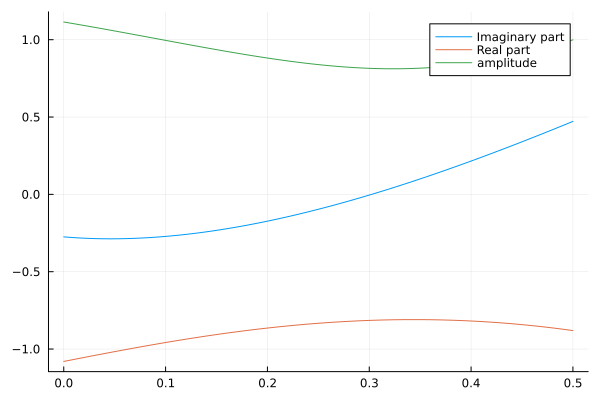

In [119]:
Plots.plot(rs,[v.im for v in vect],label="Imaginary part")
Plots.plot!(rs,[v.re for v in vect],label="Real part")
Plots.plot!(rs,[abs(v) for v in vect],label="amplitude")
